In [1]:
from sqlalchemy import create_engine
import pandas as pd

# Connexion PostgreSQL
user = 'postgres'
password = 'sarra'
host = 'localhost'
port = '5432'
database = 'DWHF'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_string)


In [2]:
query = """
SELECT
    fa.moy_bac_et,
    fa.score_final,
    da.concours_result,
    da."Nature_diplome",
    dc.sexe
FROM "Fact_Admissions" fa
JOIN dim_admission_c da ON fa."id_admisson_FK" = da."id_admisson_PK"
JOIN dim_candidats dc ON fa."id_candidat_FK" = dc."id_candidat_PK"
WHERE da.concours_result IS NOT NULL
"""


# Charger les donn√©es
df = pd.read_sql(query, engine)

# Nettoyage : convertir moyennes en float
df['moy_bac_et'] = df['moy_bac_et'].astype(str).str.replace(',', '.').astype(float)
df['score_final'] = df['score_final'].astype(str).str.replace(',', '.').astype(float)

print(df.head())

   moy_bac_et  score_final concours_result Nature_diplome sexe
0       12.20        98.12   LISTE ATTENTE            Bac    M
1       13.05        66.72   LISTE ATTENTE            Bac    M
2       12.80        38.57       REFUSE(E)            Bac    F
3       16.00        64.39        ADMIS(E)            Bac    F
4       16.56        63.28       REFUSE(E)            Bac    M


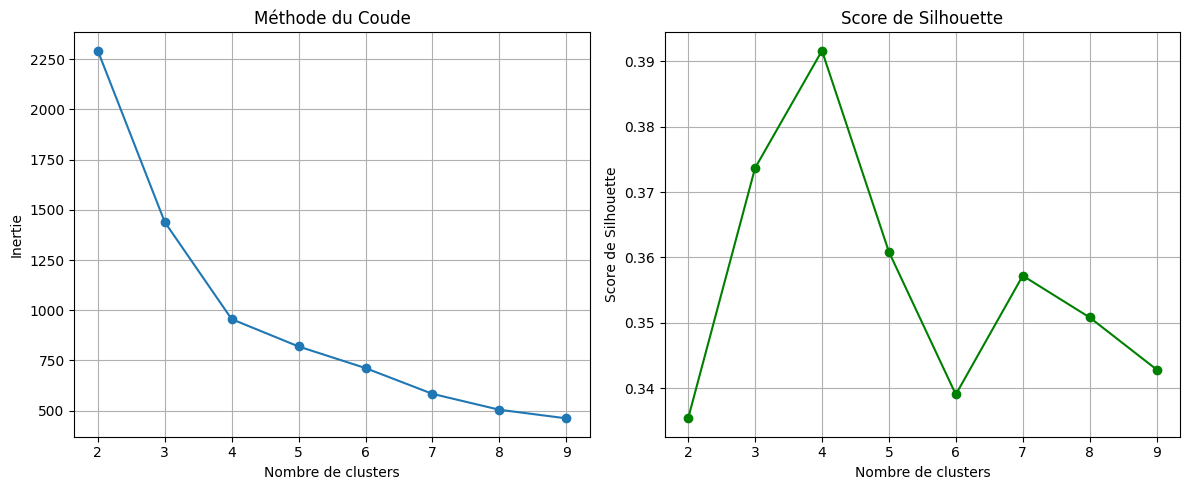

üëâ Analyse le coude + silhouette score pour choisir le meilleur K.
‚úÖ Clustering termin√© avec 3 groupes.


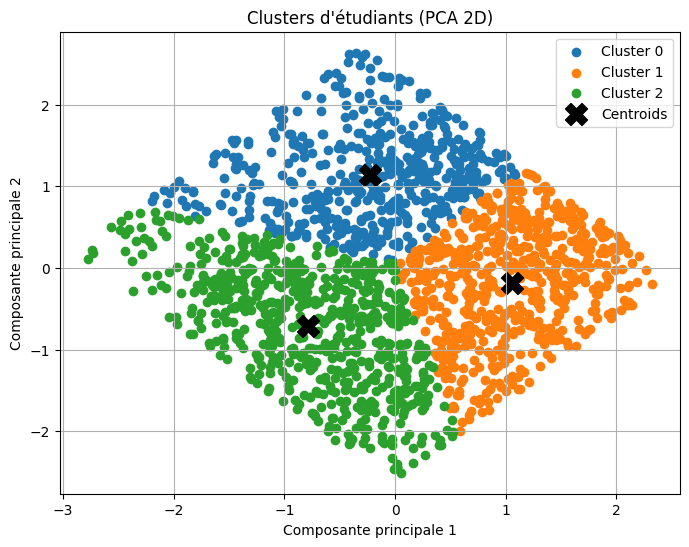


üß† Profils moyens par cluster :


moy_bac_et  score_final
cluster                         
0         14.593307    70.127588
1         10.924868    69.525248
2         12.785113    22.977805

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# ===============================
# 1Ô∏è‚É£ Utiliser ton DataFrame pr√©par√©
# ===============================

# df d√©j√† charg√© et nettoy√© par :
# - score_final
# - moy_bac_et
# - age
# - id_concours
# - nature_bac
# - code_etab_bac
# (date_ne supprim√©e comme demand√©)

# ===============================
# 2Ô∏è‚É£ S√©lection des features pour clustering
# ===============================

features_clustering = [
    'moy_bac_et',  'score_final' 
]

X_cluster = df[features_clustering].copy()

# ===============================
# 3Ô∏è‚É£ Standardisation
# ===============================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# ===============================
# 4Ô∏è‚É£ M√©thode du Coude + Silhouette
# ===============================

inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, model.labels_))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title('M√©thode du Coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Score de Silhouette')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.grid(True)

plt.tight_layout()
plt.show()

print("üëâ Analyse le coude + silhouette score pour choisir le meilleur K.")

# ===============================
# 5Ô∏è‚É£ Clustering Final (K choisi)
# ===============================

k_final = 3  # <-- √† ajuster selon ton graphe du coude !
kmeans = KMeans(n_clusters=k_final, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"‚úÖ Clustering termin√© avec {k_final} groupes.")

# ===============================
# 6Ô∏è‚É£ Visualisation 2D avec PCA
# ===============================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for cluster in range(k_final):
    plt.scatter(
        X_pca[df['cluster'] == cluster, 0],
        X_pca[df['cluster'] == cluster, 1],
        label=f"Cluster {cluster}"
    )
    
# Centroides projet√©s
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=250, c='black', marker='X', label='Centroids')

plt.title("Clusters d'√©tudiants (PCA 2D)")
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# 7Ô∏è‚É£ Analyse des groupes
# ===============================

profile_means = df.groupby('cluster')[features_clustering].mean()
print("\nüß† Profils moyens par cluster :")
display(profile_means)


In [5]:
from sqlalchemy import create_engine
import pandas as pd

# Connexion PostgreSQL
user = 'postgres'
password = 'sarra'
host = 'localhost'
port = '5432'
database = 'DWHF'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_string)


Colonnes disponibles : ['id_candidat_FK', 'moy_bac_et', 'company_id', 'position']
‚úÖ Nombre de lignes apr√®s nettoyage : 1471


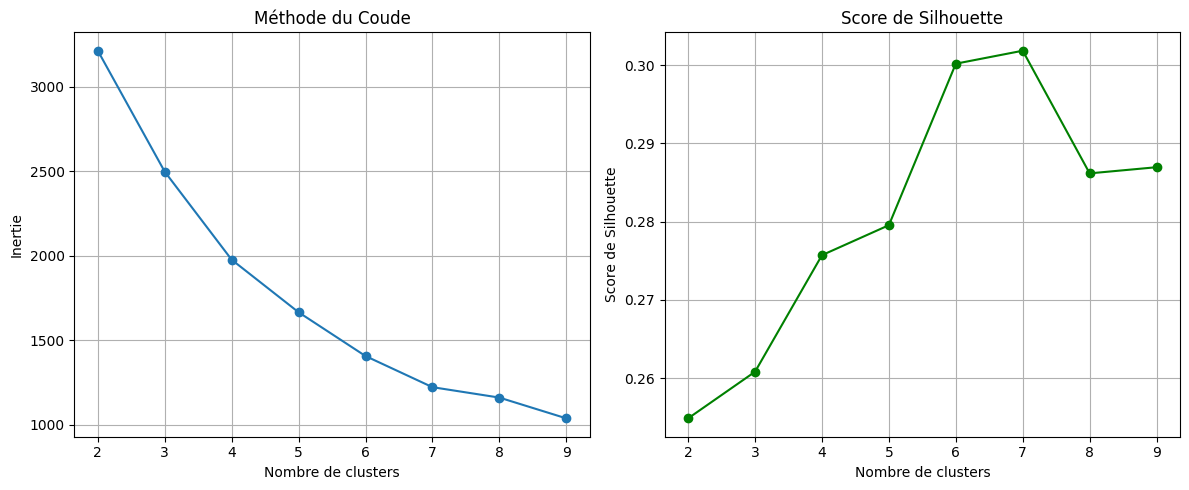

‚úÖ Clustering termin√© avec 3 groupes.


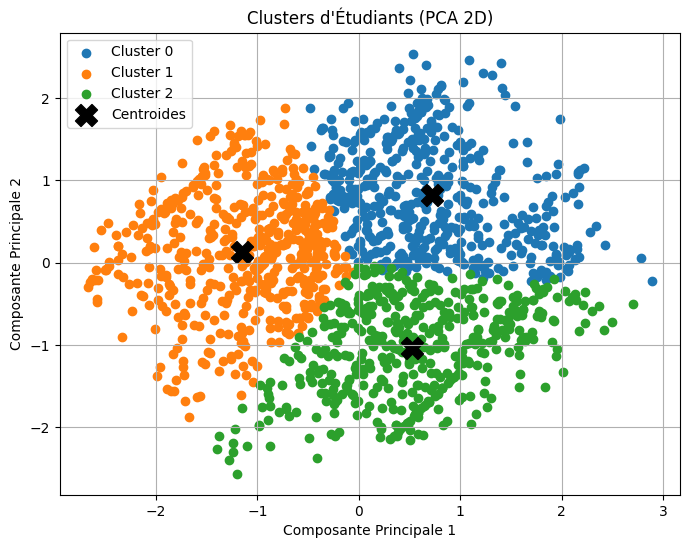


üßê Profils moyens par cluster :
         moy_bac_et  company_id    position
cluster                                    
0         14.641582  215.032454  531.817444
1         11.739191   78.425819  623.973025
2         12.089129  192.000000  186.651416


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# üì• Lecture des notes Bac
query1 = """
SELECT
    fa."id_candidat_FK",
    fa.moy_bac_et
FROM "Fact_Admissions" fa
"""
df_bac = pd.read_sql(query1, engine)



# üì• Lecture des infos sur l'employabilit√©
query2 = """
SELECT
    ca."Employee_PK" AS "id_candidat_FK",
    ca.company_id,
    ca.position
FROM "dim_employee" ca
"""
df_emp = pd.read_sql(query2, engine)

# üîó Fusion des donn√©es
df = pd.merge(df_bac, df_emp, on="id_candidat_FK", how="inner")

# üìå V√©rification des colonnes
print("Colonnes disponibles :", df.columns.tolist())

# üéØ S√©lection des variables de clustering
features_clustering = ['moy_bac_et', 'company_id', 'position']
X_cluster = df[features_clustering].dropna()

print(f"‚úÖ Nombre de lignes apr√®s nettoyage : {X_cluster.shape[0]}")

# üöÄ Encodage des variables cat√©gorielles
encoder = LabelEncoder()
X_cluster['company_id'] = encoder.fit_transform(X_cluster['company_id'].astype(str))
X_cluster['position'] = encoder.fit_transform(X_cluster['position'].astype(str))

# üìè Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# üìä M√©thode du Coude + Silhouette
inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, model.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title('M√©thode du Coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Score de Silhouette')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.grid(True)

plt.tight_layout()
plt.show()

# üìà Choix du nombre optimal de clusters apr√®s analyse graphique
k_final = 3  # üîß Change-le en fonction de la courbe

kmeans = KMeans(n_clusters=k_final, random_state=42)
X_cluster['cluster'] = kmeans.fit_predict(X_scaled)

print(f"‚úÖ Clustering termin√© avec {k_final} groupes.")

# üé® PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for cluster in range(k_final):
    plt.scatter(
        X_pca[X_cluster['cluster'] == cluster, 0],
        X_pca[X_cluster['cluster'] == cluster, 1],
        label=f"Cluster {cluster}"
    )

centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=250, c='black', marker='X', label='Centroides')

plt.title("Clusters d'√âtudiants (PCA 2D)")
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend()
plt.grid(True)
plt.show()

# üìä Analyse des groupes
profile_means = X_cluster.groupby('cluster')[features_clustering].mean()
print("\nüßê Profils moyens par cluster :")
print(profile_means)


‚úÖ Nombre de lignes apr√®s nettoyage : 999


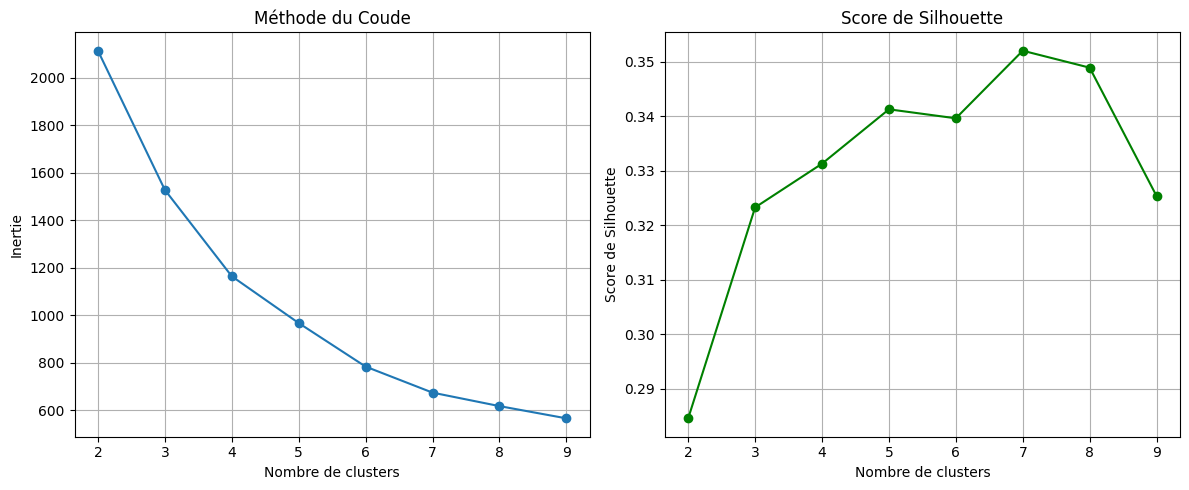

üëâ Analyse le coude + silhouette score pour choisir le meilleur K.
‚úÖ Clustering termin√© avec 3 groupes.


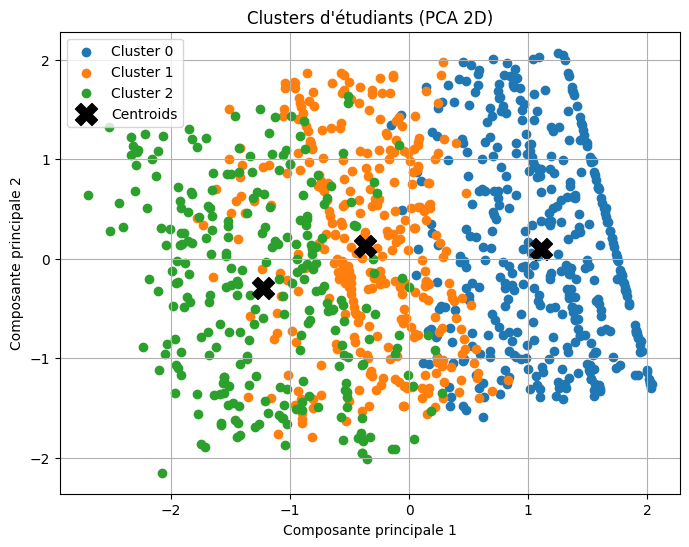


üßê Profils moyens par cluster :


Moyenne Bac (moy)  Entreprise dominante  Poste dominant
cluster                                                         
0                13.112054                   167             540
1                13.483242                   160              13
2                13.555509                     0             445


‚úÖ R√©sum√© textuel termin√©. Utilise les visualisations pour interpr√©ter davantage les groupes.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# ===============================
# 1‚É£ Chargement des donn√©es pr√©par√©es
# ===============================

# Simulation de chargement depuis une base : df est d√©j√† pr√™t avec moy_bac_et, company_name, position

# ===============================
# 2‚É£ S√©lection des features pour clustering
# ===============================

features_clustering = ['moy_bac_et', 'company_id', 'position']

X_cluster = df[features_clustering].copy()

# 2.5 Nettoyage des NaN
X_cluster = X_cluster.dropna()

# Conversion des colonnes cat√©gorielles encod√©es en float vers string pour affichage plus tard
company_decoder = dict(enumerate(df['company_name'].astype('category').cat.categories))
position_decoder = dict(enumerate(df['position'].astype('category').cat.categories))

print(f"‚úÖ Nombre de lignes apr√®s nettoyage : {X_cluster.shape[0]}")

# ===============================
# 3‚É£ Standardisation
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# ===============================
# 4‚É£ M√©thode du Coude + Silhouette
# ===============================

inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, model.labels_))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title('M√©thode du Coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.title('Score de Silhouette')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.grid(True)

plt.tight_layout()
plt.show()

print("üëâ Analyse le coude + silhouette score pour choisir le meilleur K.")

# ===============================
# 5‚É£ Clustering Final (K choisi)
# ===============================

k_final = 3  # <-- √† ajuster selon l'analyse graphique
kmeans = KMeans(n_clusters=k_final, random_state=42)
X_cluster['cluster'] = kmeans.fit_predict(X_scaled)

print(f"‚úÖ Clustering termin√© avec {k_final} groupes.")

# ===============================
# 6‚É£ Visualisation 2D avec PCA
# ===============================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for cluster in range(k_final):
    plt.scatter(
        X_pca[X_cluster['cluster'] == cluster, 0],
        X_pca[X_cluster['cluster'] == cluster, 1],
        label=f"Cluster {cluster}"
    )

centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=250, c='black', marker='X', label='Centroids')

plt.title("Clusters d'√©tudiants (PCA 2D)")
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend()
plt.grid(True)
plt.show()

# ===============================
# 7‚É£ Analyse des groupes
# ===============================

print("\nüßê Profils moyens par cluster :")
cluster_summary = X_cluster.groupby('cluster').agg({
    'moy_bac_et': 'mean',
    'company_name': lambda x: company_decoder.get(int(x.mode()[0]), 'Inconnu'),
    'position': lambda x: position_decoder.get(int(x.mode()[0]), 'Inconnu')
}).rename(columns={
    'moy_bac_et': 'Moyenne Bac (moy)',
    'company_name': 'Entreprise dominante',
    'position': 'Poste dominant'
})

display(cluster_summary)
print("\n‚úÖ R√©sum√© textuel termin√©. Utilise les visualisations pour interpr√©ter davantage les groupes.")


In [23]:
import pandas as pd

# ‚úÖ Soit en doublant les antislashs
fichier_csv = "C:\\Users\\Acer\\Downloads\\Clusters_R_sum_s.csv"

# ‚úÖ Ou en utilisant une raw string
# fichier_csv = r"C:\Users\Acer\Downloads\Clusters_R_sum_s.csv"

# Lecture du fichier CSV
df = pd.read_csv(fichier_csv)

# Affichage des 10 premi√®res lignes
print("‚úÖ Aper√ßu des donn√©es :")
display(df.head(10))


‚úÖ Aper√ßu des donn√©es :


Cluster Company Repr√©sentative Position Repr√©sentative
0        0                Ooredoo          Chef de projet
1        1               Sofrecom              Testeur QA
2        2                 Vermeg          Chef de projet